### Colin Alberts

## 0: Importing Packages and Defining Variables

### 0.0: Importing Packages

In [446]:
import numpy as np
import pandas as pd
import copy

import plotly.graph_objs as go
import matplotlib.pyplot as plt

### 0.1: Defining Variables

In [447]:
T = 1               # expiry time
r = 0.1             # no-risk interest rate
sigma = 0.1         # volatility of underlying asset
delta = 0.0         # dividend rate
E = 100.            # exercise price
S_max = 2 * E       # upper bound of price of the stock (chosen somewhat arbitrarily, unlikely a security will double in price)
S_min = 0           # this is redundant
N = int(T * 100)    # time iterations
M = int(S_max * 4)  # space iterations, accurate to about 25 cents
option_type = "Call"

# time grid
ht = T / N
ht_small = ht / 4
t_start = np.linspace(start = 0,
                      stop = ht,
                      num = 4,
                      endpoint = False)
t_end = np.linspace(start = ht,
                    stop = T,
                    num = N)
t = np.concatenate((t_start, t_end))

# spatial grid (stock's price)
s, hs = np.linspace(0,
                    S_max,
                    M + 1,
                    retstep = True)


def initial_condition(x, option):
    x_copy = x
        
    if option == 'Call':
        x_copy[:, -1] = np.maximum(s - E, 0)
        x_copy[0, :] = 0
        x_copy[-1, :] = np.exp(-r * (T - t)) * (S_max - E)
    elif option == 'Put':
        x_copy[:, -1] = np.maximum(E - s, 0)
        x_copy[0, :] = np.exp(-r * (T - t)) * (E - S_min)
        x_copy[-1, :] = 0

    return x_copy

# solution grid
solution = np.zeros(shape = (M + 1, N + 1 + 3)) # the extra 3 is for Rannacher smoothing
solution = initial_condition(solution, option_type)

# averaging at discontinuity to preserve second-order accuracy in Crank-Nicolson
solution[int(np.ceil(M / 2))][-1] = (solution[int(np.ceil(M / 2)) - 1][-1] + solution[int(np.ceil(M / 2)) + 1][-1]) / 2

### 0.2: Optimization Functions

In [448]:
# Thomas Algorithm, is only stable when matrix is diagonally dominant or SPD.
def thomas(a, b, c, d):
    dim = len(d)  # number of equations to be solved
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    
    for i in range(1, dim):
        w = ac[i - 1] / bc[i - 1]
        bc[i] = bc[i] - w * cc[i - 1]
        dc[i] = dc[i] - w * dc[i - 1]
        
    x = bc
    x[-1] = dc[-1] / bc[-1]

    for j in range(dim - 2, -1, -1):
        x[j] = (dc[j] - cc[j] * x[j + 1]) / bc[j]
        
    return x

In [449]:
# Checking diagonal dominance for Thomas Algorithm stability
def check_diag_dominant(mat):
    diags = np.abs(np.diag(mat))
    return np.all(diags >= np.sum(np.abs(mat), axis=1).T - diags)

# 1: Crank-Nicolson Implementation

## 1.1: Methods

### 1.1.1: Crank-Nicolson with Rannacher Smoothing
The [link](https://github.com/katpirat/Finite-difference-for-PDEs/blob/main/FD_for_BlackScholes_pricing.py) to the source that I ~~stole~~ took inspiration from.

In [450]:
def crank(s, sigma, r, delta, solution):
    crank_solution = copy.deepcopy(solution)
    
    # Crank-Nicolson vectors
    u_vec = (sigma ** 2 * s ** 2) / (4 * hs ** 2) - (r - delta) * s / (4 * hs)
    v_vec = (sigma ** 2 * s ** 2) / (2 * hs ** 2) + r / 2
    w_vec = (sigma ** 2 * s ** 2) / (4 * hs ** 2) + (r - delta) * s / (4 * hs)
    
    P_mat_C = -np.diag(u_vec[2:-1] * ht, -1) + np.diag(v_vec[1:-1] * ht) - np.diag(w_vec[1:-2] * ht, 1) + np.identity(M - 1)
    
    offset_1 = np.zeros(M - 1)
    offset_2 = np.zeros(M - 1)
    
    # Backward Euler setup
    alpha = ht_small * (sigma ** 2 * s ** 2 / hs ** 2 - s / hs * (r - delta)) / 2
    beta = ht_small * (r + sigma ** 2 * s ** 2 / hs ** 2)
    gamma = ht_small * (s ** 2 * sigma ** 2 / hs ** 2 + s / hs * (r - delta)) / 2
    
    P_mat_E = -np.diag(alpha[2:-1], -1) + np.diag(beta[1:-1]) - np.diag(gamma[1:-2], 1) + np.identity(M - 1)
    
    offset = np.zeros(M - 1)
    
    for i in range(N + 3, 0, -1):
        if i > N - 1 and option_type != "Call": # going to need to remove the option_type condition at some point
            if not check_diag_dominant(P_mat_E):
                print("Matrix is NOT diagonally dominant!!!")
                
            offset[0], offset[-1] = crank_solution[0, i] * alpha[1], crank_solution[-1, i] * gamma[-1]
            
        
            crank_solution[1:-1, i - 1] = thomas(np.diag(P_mat_E, -1),
                                                 np.diag(P_mat_E),
                                                 np.diag(P_mat_E, 1),
                                                 crank_solution[1:-1, i] - offset * ht_small)
        else:
            if not check_diag_dominant(P_mat_C):
                print("Matrix is NOT diagonally dominant!!!")
                
            offset_1[0] = crank_solution[0, i] * u_vec[1] * -2
            offset_1[-1] = crank_solution[-1, i] * w_vec[-1] * -2

            offset_2[0] = crank_solution[0, i - 1] * u_vec[1] * -2
            offset_2[-1] = crank_solution[-1, i - 1] * w_vec[-1] * -2
            
            Q_mat = np.diag(u_vec[2:-1] * ht, -1) - np.diag(v_vec[1:-1] * ht) + np.diag(w_vec[1:-2] * ht, 1) + np.identity(M - 1)
            RHS = np.dot(Q_mat, crank_solution[1:-1, i]) - ht / 2 * (offset_1 + offset_2)
                
            crank_solution[1:-1, i - 1] = thomas(np.diag(P_mat_C, -1),
                                                np.diag(P_mat_C),
                                                np.diag(P_mat_C, 1),
                                                RHS)
        
    df = pd.DataFrame(crank_solution, columns = list(map(lambda i: str(ht * i), 
                                                         range(crank_solution.shape[1]))))

    return df

### 1.1.2: Backward Euler

In [451]:
# def backward_euler(s, sigma, r, delta, solution):
#     crank_solution = copy.deepcopy(solution)
    
#     alpha = ht * (sigma ** 2 * s ** 2 / hs ** 2 - s / hs * (r - delta)) / 2
#     beta = ht * (r + sigma ** 2 * s ** 2 / hs ** 2)
#     gamma = ht * (s ** 2 * sigma ** 2 / hs ** 2 + s / hs * (r - delta)) / 2
    
#     P_mat = -np.diag(alpha[2:-1], -1) + np.diag(beta[1:-1]) - np.diag(gamma[1:-2], 1) + np.identity(M - 1)
    
#     offset = np.zeros(M - 1)
    
#     for i in range(N, 0, -1):
#         offset[0], offset[-1] = crank_solution[0, i] * alpha[1], crank_solution[-1, i] * gamma[-1]
        
#         crank_solution[1:-1, i - 1] = thomas(np.diag(P_mat, -1),
#                                              np.diag(P_mat),
#                                              np.diag(P_mat, 1),
#                                              crank_solution[1:-1, i] - offset * ht)
        
#     df = pd.DataFrame(crank_solution, columns = list(map(lambda i: str(ht * i), 
#                                                          range(N + 1))))
#     return df

## 1.2: Plot Function

In [452]:
def surface_plot(solution):
    X, Y = np.meshgrid(t[::-1], s)
    
    fig = go.Figure(data=[go.Surface(z=solution, x=Y, y=X)])
    
    fig.update_layout(title='Price Surface', 
                      autosize=False,
                      scene=dict(xaxis_title='Price',
                                 yaxis_title='Time',
                                 zaxis_title='Payoff'))
    fig.show()

## 1.3: Solve and Plot

In [453]:
crank_sol = crank(s, sigma, r, delta, solution)
surface_plot(crank_sol)

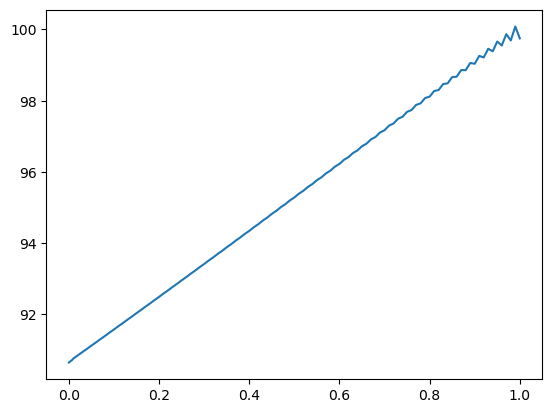

In [454]:
# print(crank_sol)
# something is going on with the spurious oscillations of the system
# are attemping to apply BE to make the oscillations go away, this seems to not be working
plt.plot(t, crank_sol.iloc[-2, :])